In [1]:
import cv2
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Function to unpickle the dataset
def unpickle(file):
    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data

# function to convert  the record into an image
def rec_to_img(rec):
    r = rec[:1024].reshape((32,32))
    g = rec[1024:-1024].reshape((32,32))
    b = rec[-1024:].reshape((32,32))
    img = cv2.merge((r,g,b))
    return img

**Loading the dataset all parts**

In [3]:
parts = []
for batch in [1,2,3,4,5]:
    batch = unpickle("cifar-10-batches-py/data_batch_" + str(batch))
    parts.append(batch)
    
# Getting the labels and data from the loaded dictinary
label = []
data = []

# Get the data and labels from the parts
for part in parts:
    data.append(part[b'data'])
    label.append(part[b'labels'])
    
# Combine all the parts into single one
com_labels = np.concatenate(label)
com_data = np.concatenate(data)

# After combining the parts here is the data shape
print("Labels shape:", com_labels.shape)
print("Data shape:  ", com_data.shape)

Labels shape: (50000,)
Data shape:   (50000, 3072)


**Loading the label names**

In [4]:
classes_names = unpickle("cifar-10-batches-py/batches.meta")[b'label_names']
classes_names = [i.decode() for i in classes_names]

**Plots od some images of the dataset**

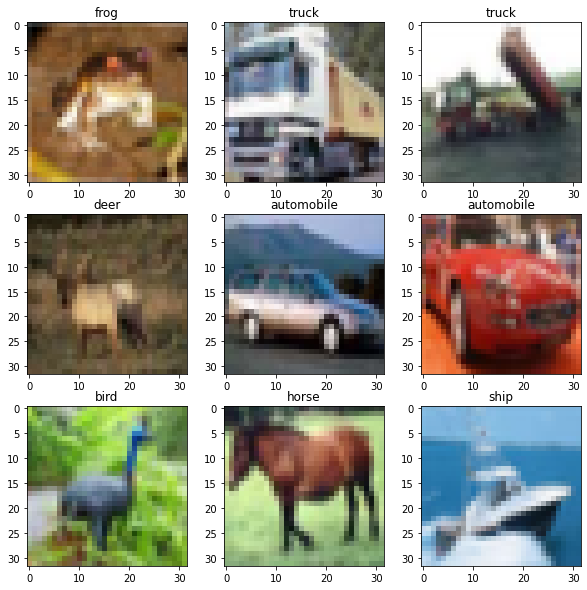

In [5]:
plt.figure(figsize = (10,10))
for i in range(9):
    plt.subplot(3,3, i+1)
    plt.title(classes_names[com_labels[i]])
    img = rec_to_img(com_data[i])
    plt.imshow(img)

**Here are we loading the complete images and names**

In [6]:
com_images = []
com_names = []

for n, data in enumerate(com_data):
    img = rec_to_img(data)
    com_images.append(img)
    com_names.append(classes_names[com_labels[n]])

In [7]:
print(np.shape(com_images))
print(np.shape(com_names))

(50000, 32, 32, 3)
(50000,)


**All Classes Images distributions**

In [8]:
pd.Series(com_names).value_counts()

bird          5000
cat           5000
frog          5000
ship          5000
dog           5000
airplane      5000
truck         5000
horse         5000
automobile    5000
deer          5000
dtype: int64

<AxesSubplot:ylabel='None'>

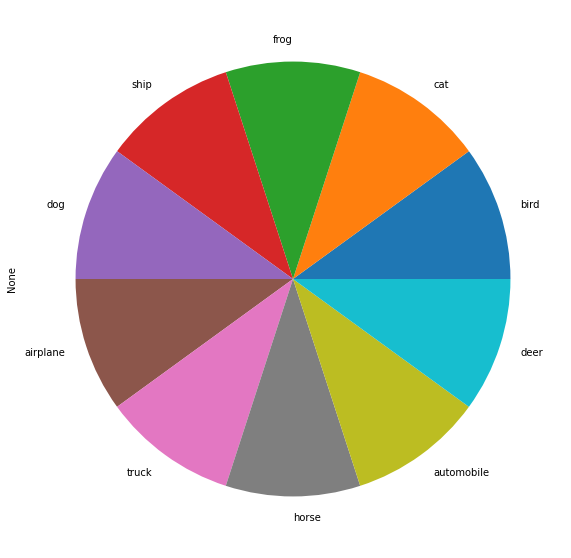

In [9]:
pd.Series(com_names).value_counts().plot(kind = 'pie', figsize=(10,10))

In [10]:
from tensorflow.keras.utils import to_categorical
com_labels = to_categorical(com_labels)
com_labels[:10]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

# Applying the CNN over the CIFAR-10 Dataset

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(com_images, com_labels, test_size=0.2, random_state=42)
print("Train data: ", np.shape(X_train))
print("Test data:", np.shape(X_test))

Train data:  (40000, 32, 32, 3)
Test data: (10000, 32, 32, 3)


In [13]:
# Creating the Model of Tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, AveragePooling2D

model = Sequential()

# First Layer
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(AveragePooling2D((2, 2)))

# Second Layer
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(AveragePooling2D((2, 2)))

# Third Layer
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(AveragePooling2D((2, 2)))

# Flatten Layer
model.add(Flatten())
model.add(Dense(128, activation='relu'))

# Output Layer
model.add(Dense(10, activation='softmax'))

# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
average_pooling2d (AveragePo (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
average_pooling2d_1 (Average (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         7

In [14]:
!pip install visualkeras

     |████████████████████████████████| 994 kB 493 kB/s eta 0:00:01


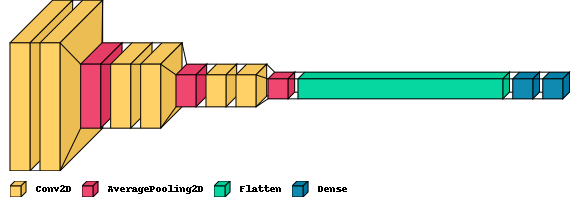

In [15]:
import visualkeras
visualkeras.layered_view(model,legend=True)

In [16]:
history = model.fit(np.array(X_train), y_train, epochs=20, batch_size=32, validation_data=(np.array(X_test), y_test))

Epoch 1/20
1250/1250 [==============================] - 54s 43ms/step - loss: 1.5752 - accuracy: 0.4345 - val_loss: 1.1831 - val_accuracy: 0.5793
Epoch 2/20
1250/1250 [==============================] - 56s 44ms/step - loss: 1.0708 - accuracy: 0.6254 - val_loss: 0.9471 - val_accuracy: 0.6683
Epoch 3/20
1250/1250 [==============================] - 54s 43ms/step - loss: 0.8728 - accuracy: 0.6959 - val_loss: 0.9779 - val_accuracy: 0.6676
Epoch 4/20
1250/1250 [==============================] - 57s 46ms/step - loss: 0.7399 - accuracy: 0.7441 - val_loss: 0.8374 - val_accuracy: 0.7236
Epoch 5/20
1250/1250 [==============================] - 57s 45ms/step - loss: 0.6348 - accuracy: 0.7792 - val_loss: 0.8260 - val_accuracy: 0.7224
Epoch 6/20
1250/1250 [==============================] - 58s 47ms/step - loss: 0.5375 - accuracy: 0.8102 - val_loss: 0.7982 - val_accuracy: 0.7387
Epoch 7/20
1250/1250 [==============================] - 58s 46ms/step - loss: 0.4585 - accuracy: 0.8399 - val_loss: 0.8905 -

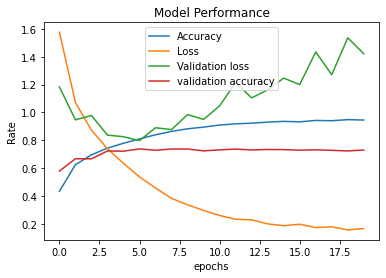

In [17]:
# Model Performance graph
plt.plot(range(20), history.history['accuracy'], label = "Accuracy")
plt.plot(range(20), history.history['loss'], label = "Loss")
plt.plot(range(20), history.history['val_loss'], label = "Validation loss")
plt.plot(range(20), history.history['val_accuracy'], label = "validation accuracy")
plt.title("Model Performance")
plt.xlabel("epochs")
plt.ylabel("Rate")
plt.legend()
plt.show()

In [18]:
prediction = model.predict(np.array(X_test)) 

In [19]:
y_pred = [np.argmax(i) for i in prediction]
y_actual = [np.argmax(i) for i in y_test]

In [20]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

# function for evaluation metrics precision, recall, f1 etc
def modelEvaluation(predictions, y_test_set, model_name):
    # Print model evaluation to predicted result    
    print("==========",model_name,"==========")
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test_set, predictions)))    
    print ("\nClassification report : \n", classification_report(y_test_set, predictions))
    print ("\nConfusion Matrix : \n", confusion_matrix(y_test_set, predictions))
    plt.figure(figsize=(10,10))
    sns.heatmap(confusion_matrix(y_test_set, predictions),annot=True, fmt='g',cmap='viridis')
    plt.tight_layout()
    plt.savefig(model_name + "_confusion matrix.jpg")
    plt.show()
    results = [accuracy_score(y_test_set, predictions), precision_score(y_test_set, predictions, average='macro'),
              recall_score(y_test_set, predictions, average='macro'),f1_score(y_test_set, predictions, average='macro')]
    return results

In [21]:
# Model Accuracy score for the CNN
from sklearn.metrics import accuracy_score
print("Accuracy Score: ", round(accuracy_score(y_actual, y_pred), 3))

Accuracy Score:  0.73


========== CNN Model ==========

Accuracy on validation set: 0.7305

Classification report : 
               precision    recall  f1-score   support

           0       0.67      0.80      0.73       973
           1       0.86      0.87      0.87       979
           2       0.65      0.63      0.64      1030
           3       0.54      0.55      0.55      1023
           4       0.69      0.68      0.68       933
           5       0.67      0.57      0.62      1015
           6       0.75      0.83      0.78       996
           7       0.76      0.75      0.76       994
           8       0.85      0.83      0.84      1017
           9       0.88      0.79      0.83      1040

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000


Confusion Matrix : 
 [[782  10  40  26  13   3  12   7  56  24]
 [ 22 851   4  13   2   5   5   4  23  50]
 [105   6 648  61  69  41  61  27  10 

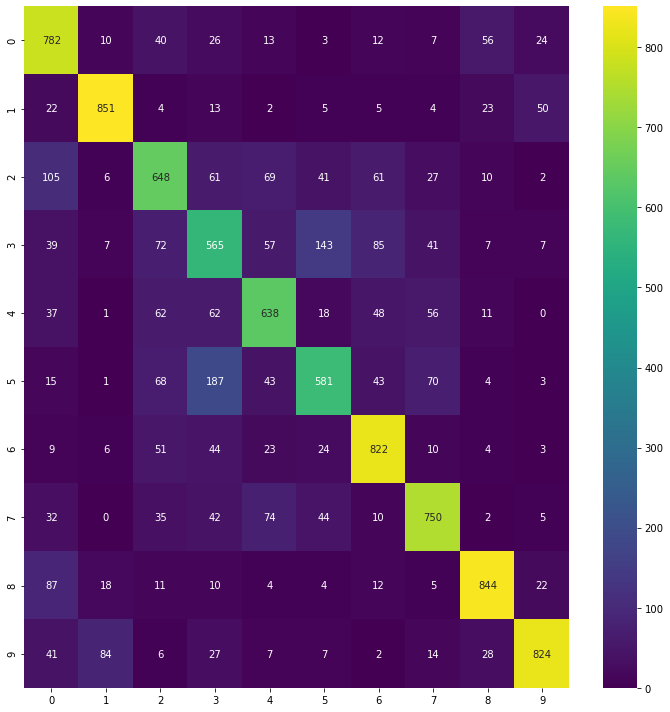

In [22]:
myCNNResults = modelEvaluation(y_pred, y_actual, "CNN Model")

In [23]:
# Saving the CNN Model
model.save("CNN-Model.h5")

# Alex Net Implementation for the features extractions

**Alexnet architecture for 32 by 32 size image**<br>
ref: https://analyticsindiamag.com/hands-on-guide-to-implementing-alexnet-with-keras-for-multi-class-image-classification/ 

In [24]:
# Importing library
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
import numpy as np

np.random.seed(1000)

# Instantiation
AlexNet = Sequential()

# 1st Convolutional Layer
AlexNet.add(Conv2D(filters=96, input_shape=(32,32,3), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

# 2nd Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

# 3rd Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

# 4th Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

# 5th Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
AlexNet.add(Flatten())

# 1st Fully Connected Layer
AlexNet.add(Dense(4096, input_shape=(32,32,3,)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

# Add Dropout to prevent overfitting
AlexNet.add(Dropout(0.4))

# 2nd Fully Connected Layer
AlexNet.add(Dense(4096))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

# Add Dropout
AlexNet.add(Dropout(0.4))

# 3rd Fully Connected Layer
AlexNet.add(Dense(1000))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

# Add Dropout
AlexNet.add(Dropout(0.4))

# Output Layer
AlexNet.add(Dense(10))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('softmax'))

# Model Compilation
AlexNet.compile(loss = keras.losses.categorical_crossentropy, optimizer= 'adam', metrics=['accuracy'])

# Model Summary
AlexNet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 8, 8, 96)          34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 96)          384       
_________________________________________________________________
activation (Activation)      (None, 8, 8, 96)          0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 96)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 256)         614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
activation_1 (Activation)    (None, 4, 4, 256)        

In [26]:
AlexNet.fit(np.array(X_train), y_train, epochs=50, batch_size=32, validation_data=(np.array(X_test),y_test))

Epoch 1/50
1250/1250 [==============================] - 199s 159ms/step - loss: 1.0330 - accuracy: 0.6442 - val_loss: 1.3637 - val_accuracy: 0.5472
Epoch 2/50
1250/1250 [==============================] - 199s 159ms/step - loss: 0.9380 - accuracy: 0.6806 - val_loss: 1.2214 - val_accuracy: 0.5825
Epoch 3/50
1250/1250 [==============================] - 200s 160ms/step - loss: 0.8477 - accuracy: 0.7118 - val_loss: 1.3806 - val_accuracy: 0.5264
Epoch 4/50
1250/1250 [==============================] - 199s 159ms/step - loss: 0.7544 - accuracy: 0.7458 - val_loss: 1.4427 - val_accuracy: 0.5521
Epoch 5/50
1250/1250 [==============================] - 200s 160ms/step - loss: 0.6614 - accuracy: 0.7796 - val_loss: 1.1235 - val_accuracy: 0.6312
Epoch 6/50
1250/1250 [==============================] - 200s 160ms/step - loss: 0.5779 - accuracy: 0.8072 - val_loss: 1.7550 - val_accuracy: 0.5057
Epoch 7/50
1250/1250 [==============================] - 200s 160ms/step - loss: 0.5009 - accuracy: 0.8370 - val_

**FC6 Model**

In [27]:
from tensorflow.keras.models import Model

fc6_model = Model(inputs= AlexNet.inputs, outputs = [AlexNet.layers[-5].output])
fc6_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6_input (InputLayer)  [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 96)          34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 96)          384       
_________________________________________________________________
activation (Activation)      (None, 8, 8, 96)          0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 96)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 256)         614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 256)        

In [28]:
linear_features = []

for img in com_images:
    print(len(linear_features), end = '\r')
    data = fc6_model.predict(np.array([img]))[0]
    linear_features.append(data)

In [29]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(com_names)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(linear_features, y, test_size=0.2, random_state=42)

In [31]:
print("X_train data: ", np.shape(X_train))
print("X_test  data: ", np.shape(X_test))

X_train data:  (40000, 1000)
X_test  data:  (10000, 1000)


========== Decision Tree Classifier ==========

Accuracy on validation set: 0.6477

Classification report : 
               precision    recall  f1-score   support

           0       0.64      0.71      0.68       973
           1       0.75      0.73      0.74       979
           2       0.59      0.54      0.57      1030
           3       0.48      0.48      0.48      1023
           4       0.55      0.64      0.59       933
           5       0.56      0.55      0.55      1015
           6       0.74      0.70      0.72       996
           7       0.72      0.70      0.71       994
           8       0.78      0.74      0.76      1017
           9       0.68      0.70      0.69      1040

    accuracy                           0.65     10000
   macro avg       0.65      0.65      0.65     10000
weighted avg       0.65      0.65      0.65     10000


Confusion Matrix : 
 [[693  29  53  28  33   4   6  23  65  39]
 [ 36 716   9  19  17   3  17   9  37 116]
 [ 76  11 560  92 112  

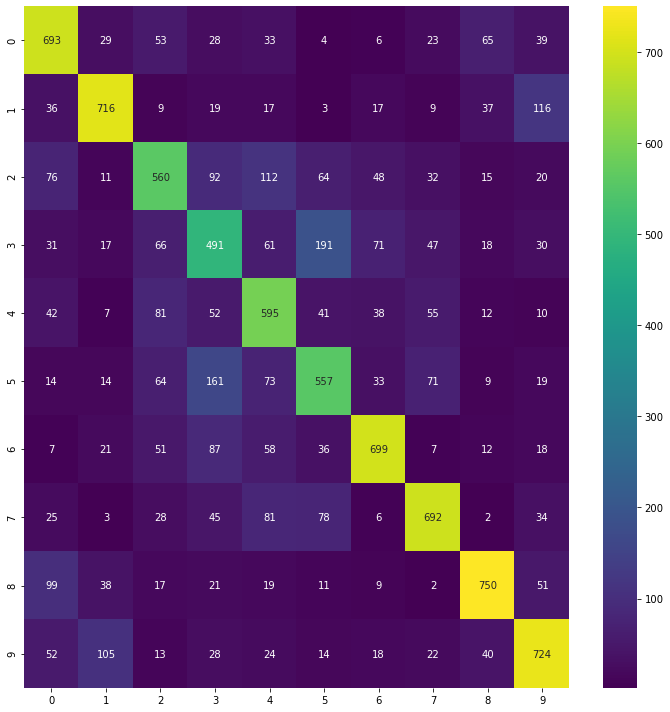

In [32]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)

fc6_results = modelEvaluation(y_pred, y_test, "Decision Tree Classifier")

**FC7 LAYER Model**

In [35]:
from tensorflow.keras.models import Model

fc7_model = Model(inputs= AlexNet.inputs, outputs = [AlexNet.layers[-3].output])
fc7_model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6_input (InputLayer)  [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 96)          34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 96)          384       
_________________________________________________________________
activation (Activation)      (None, 8, 8, 96)          0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 96)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 256)         614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 256)        

In [36]:
linear_features = []

for img in com_images:
    print(len(linear_features), end = '\r')
    data = fc7_model.predict(np.array([img]))[0]
    linear_features.append(data)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(linear_features, y, test_size=0.2, random_state=42)
print("X_train data: ", np.shape(X_train))
print("X_test  data: ", np.shape(X_test))

X_train data:  (40000, 10)
X_test  data:  (10000, 10)


========== Decision Tree Classifier ==========

Accuracy on validation set: 0.6440

Classification report : 
               precision    recall  f1-score   support

           0       0.65      0.69      0.67       973
           1       0.73      0.72      0.73       979
           2       0.58      0.54      0.56      1030
           3       0.46      0.48      0.47      1023
           4       0.56      0.61      0.59       933
           5       0.56      0.56      0.56      1015
           6       0.74      0.71      0.72       996
           7       0.72      0.68      0.70       994
           8       0.77      0.76      0.77      1017
           9       0.70      0.68      0.69      1040

    accuracy                           0.64     10000
   macro avg       0.65      0.64      0.65     10000
weighted avg       0.65      0.64      0.64     10000


Confusion Matrix : 
 [[674  33  53  36  25   7   6  19  75  45]
 [ 34 706  11  26  13  12  16   8  41 112]
 [ 78  12 560 100 100  

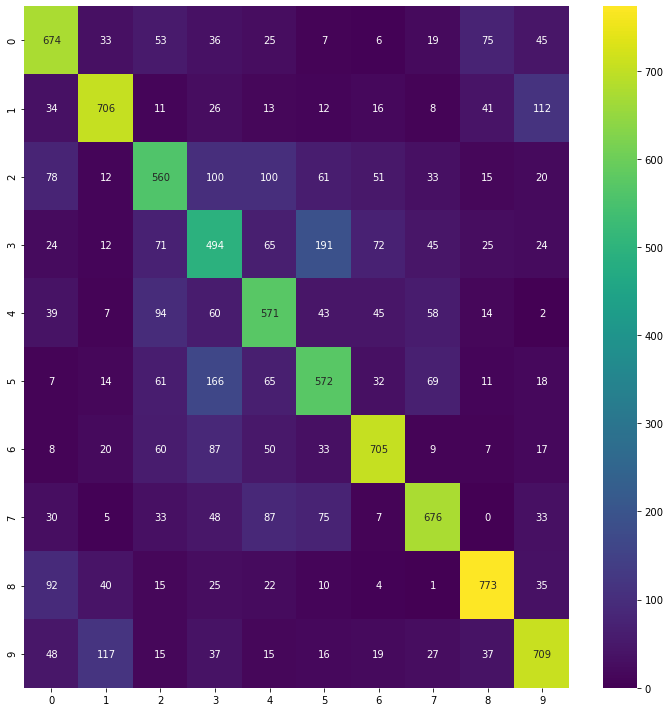

In [38]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)

fc7_results = modelEvaluation(y_pred, y_test, "Decision Tree Classifier")

**FC6 and FC7 Models results comparisons**

<AxesSubplot:xlabel='metrics'>

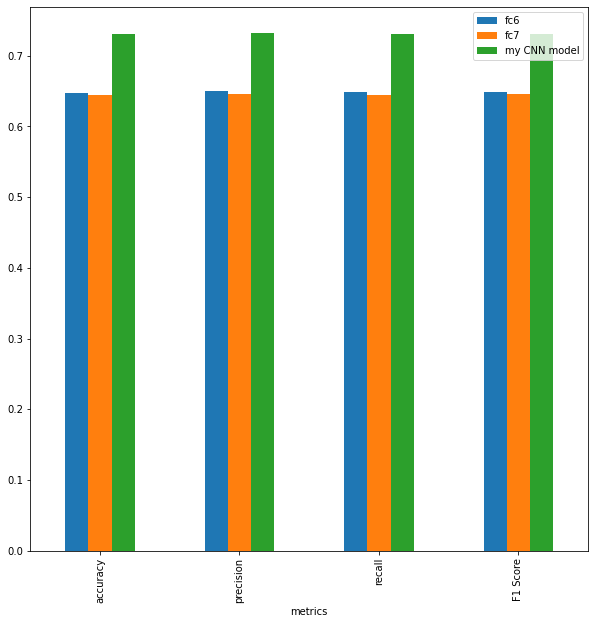

In [39]:
df = pd.DataFrame()

df['metrics'] = ['accuracy', 'precision', 'recall', 'F1 Score']

df['fc6'] = fc6_results
df['fc7'] = fc7_results
df['my CNN model'] = myCNNResults

df.set_index("metrics").plot(kind = 'bar', figsize=(10,10))

In [40]:
df

,metrics,fc6,fc7,my CNN model
0,accuracy,0.647700,0.644000,0.730500
1,precision,0.649990,0.646561,0.732186
2,recall,0.648534,0.644570,0.731263
3,F1 Score,0.648539,0.645231,0.730297
